## FADM-GPS : Frequency attributed diffusion model for generating pulsatile signals 

In [1]:
import sys
# setting path
sys.path.append('../')

import os
import re
import numpy as np
import matplotlib.pyplot as plt
import copy
from argparse import ArgumentParser

from Benchmarks.Models.BenchmarkCaller import *
from Utilities.EvaluationMain import *
from Utilities.Utilities import ReadYaml, SerializeObjects, DeserializeObjects, LoadModelConfigs, LoadParams



## GPU selection
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]= "3"

# TensorFlow wizardry
config = tf.compat.v1.ConfigProto()
# Don't pre-allocate memory; allocate as-needed
config.gpu_options.allow_growth = True
# Only allow a total of half the GPU memory to be allocated
config.gpu_options.per_process_gpu_memory_fraction = 1.0
# Create a session with the above options specified.
tf.compat.v1.keras.backend.set_session(tf.compat.v1.Session(config=config))         

In [2]:
YamlPath = './Config/EvalConfigART.yml'
ModelConfigs = ReadYaml(YamlPath)
[i for i in ModelConfigs]

['Common_Info',
 'BaseVAE_ART_30',
 'BaseVAE_ART_50',
 'FACVAE_ART_30',
 'FACVAE_ART_50',
 'ConVAE_ART_30',
 'ConVAE_ART_50',
 'TCVAE_ART_30',
 'TCVAE_ART_50']

In [3]:
ConfigName = 'EvalConfigART'
ConfigSpecName = 'FACVAE_ART_30'
EvalConfigs = ReadYaml(YamlPath)

In [19]:
ConfigName = 'ConVAE_ART_30'
ModelConfigSet, ModelLoadPath = LoadModelConfigs(ConfigName, Comp=False)

# Loading parameters for the evaluation
Params = LoadParams(ModelConfigSet, EvalConfigs[ConfigName])
Params['Common_Info'] = EvalConfigs['Common_Info']

# Object save path
ObjLoadPath = './EvalResults/Instances/Obj_'+ConfigName+'.pkl'
SampZjSavePath = './Data/IntermediateData/'+ConfigName+'_SampZj_'+str(Params['NSelZ'])+'.npy'

# Loading data
TrData = np.load('../Data/ProcessedData/Tr'+str(Params['SigType'])+'.npy').astype('float32')
VallData = np.load('../Data/ProcessedData/Val'+str(Params['SigType'])+'.npy').astype('float32')

# Intermediate parameters 
SigDim = VallData.shape[1]
DataSize = VallData.shape[0]

In [20]:
# Calling Modesl
BenchModel, _, AnalData = ModelCall (ModelConfigSet, ConfigName, TrData, VallData, LoadWeight=True, Reparam=True, ReparaStd=Params['ReparaStd'], ModelSaveName=ModelLoadPath) 


## The generation model for evaluation
GenModel = BenchModel.get_layer('ReconModel')

## The sampling model for evaluation
Inp_Enc = BenchModel.get_layer('Inp_Enc')
Zs = BenchModel.get_layer('Zs').output

if Params['SecDataType'] == 'CON':
    Inp_Cond = BenchModel.get_layer('Inp_Cond')
    SampModel = Model([Inp_Enc.input, Inp_Cond.input], Zs)
else:
    SampModel = Model(Inp_Enc.input, Zs)

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Inp_Enc (InputLayer)            [(None, 1000)]       0                                            
__________________________________________________________________________________________________
tf.signal.frame_2 (TFOpLambda)  (None, 20, 50)       0           Inp_Enc[0][0]                    
__________________________________________________________________________________________________
bidirectional_12 (Bidirectional (None, 20, 50)       11550       tf.signal.frame_2[0][0]          
__________________________________________________________________________________________________
bidirectional_13 (Bidirectional (None, 20, 50)       11550       bidirectional_12[0][0]           
____________________________________________________________________________________________

In [21]:
Eval = Evaluator(MinFreq = Params['MinFreq'], MaxFreq = Params['MaxFreq'], SimSize = Params['SimSize'], NMiniBat = Params['NMiniBat'], 
       NGen = Params['NGen'], ReparaStdZj = Params['ReparaStdZj'], NSelZ = Params['NSelZ'], SampBatchSize = Params['SampBatchSize'], 
       GenBatchSize = Params['GenBatchSize'], GPU = Params['GPU'])

# Later, when you want to restore those objects
# Create a new instance
NewEval = Evaluator()
# Populate it with the saved data
DeserializeObjects(NewEval, ObjLoadPath)

#### Selecting post Samp_Zj for generating plausible signals

In [22]:
# MetricCut: The threshold value for selecting Zs whose Entropy of PSD (i.e., SumH) is less than the MetricCut
MetricCut = 10.
PostSamp_Zj, NestedZFix = NewEval.SelPostSamp_Zj( Params['MetricCut'])

The total number of sets in NestedZs: 2374


In [30]:
NewEval.MI_zPSD_ZjZ, NewEval.MI_fcPE_CaCr, NewEval.MI_zPSD_CrZj

(0.9243237783267593, -0.032087593950670956, 1.3819986420059163)

#### Post EvalKld_TrueGen

1/1 [==============================] - 2s 2s/step
KldPSD_GenTrue:  0.012343248242059622
KldPSD_TrueGen:  0.014586701081894776
MeanKld_GTTG:  0.0134649746619772


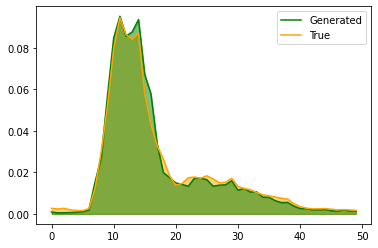

In [23]:
NewEval.GenModel = GenModel
NewEval.KLD_TrueGen(SecDataType='CON', RepeatSize = 1, AnalData=AnalData[:]) 

In [27]:
NewEval.KLD_TrueGen()

AttributeError: 'Evaluator' object has no attribute 'SecDataType'

### Qualitative evaluation

#### Exploring candidates using FreqIDs

In [17]:
TrackerCandZ = NewEval.TrackerCandZ
BestZsMetrics = NewEval.BestZsMetrics
NewEval.CandFreqIDs
LatDim = 30

#### Visualization of signals given Z values

In [18]:
FreqID = 9
ZFixSubID = 5
assert ZFixSubID < len(NestedZFix[FreqID]), 'ZFixSubID must be smaller than ' + str(len(NestedZFix[FreqID]))

RecPred, HH,HL,LH, LL = VisReconGivenZ_FCA (FeatGenModel,  ReconModel, LatDim, NestedZFix[FreqID][ZFixSubID], Mode='Origin', N_Gen=300, MinFreqR=0, MaxFreqR=0.05)

NameError: name 'VisReconGivenZ_FCA' is not defined

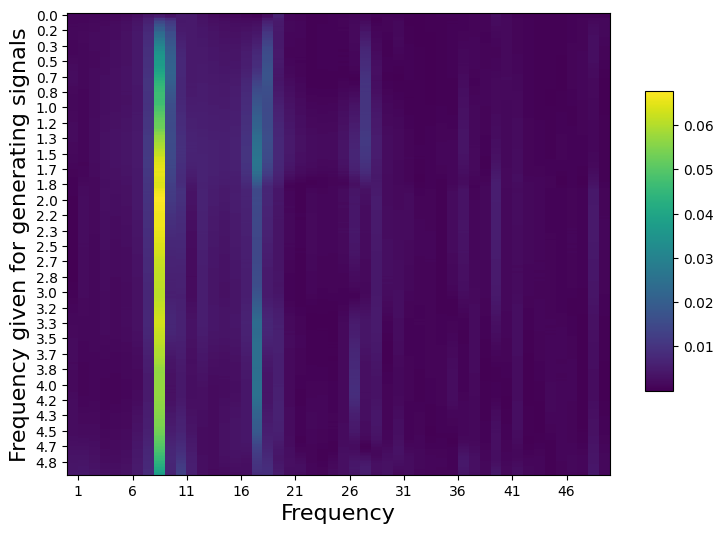

In [141]:
HeatMapFreqZ_FCA (FeatGenModel,  ReconModel, LatDim, NestedZFix[FreqID][ZFixSubID], N_Gen=300)

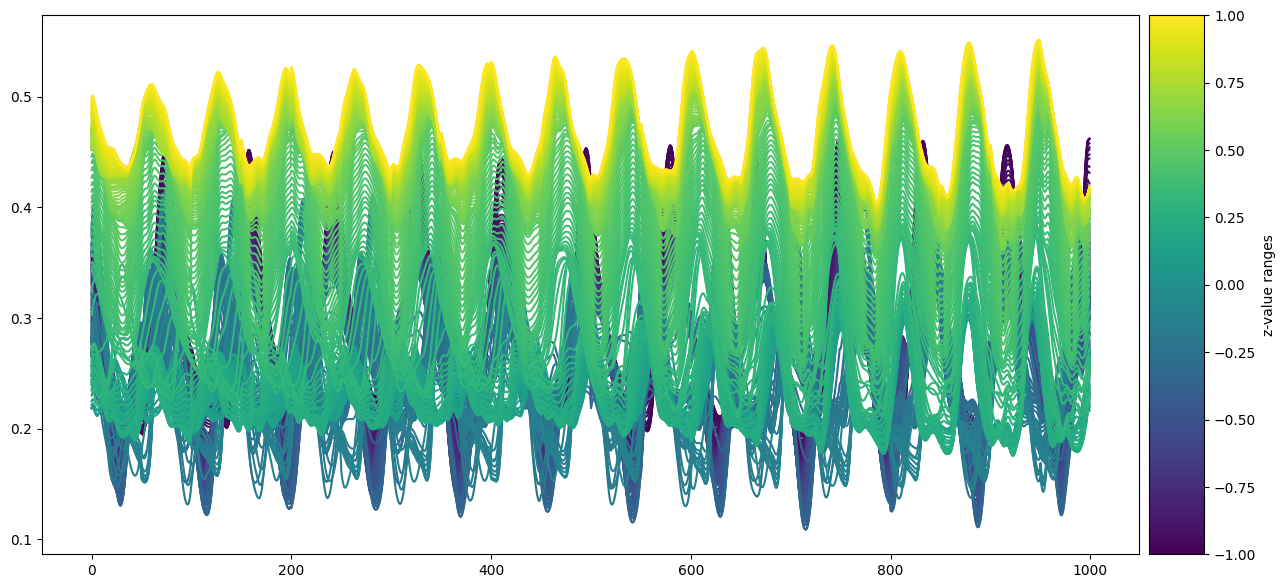

In [142]:
FcCommFix = {0: 0.05, 1: 0.05}
FcEachFix  = {0: 0.01, 1: 0.01, 2: 0.01, 3: 0.01}
RecPred, HH,HL,LH, LL = VisReconGivenFC_ZA (FeatGenModel,  ReconModel, LatDim, FcCommFix, FcEachFix,  Mode='Origin', N_Gen=300, MinZval = -1., MaxZval = 1., CutLower=-0.1, CutUpper = 0.1)

(100, 1000)


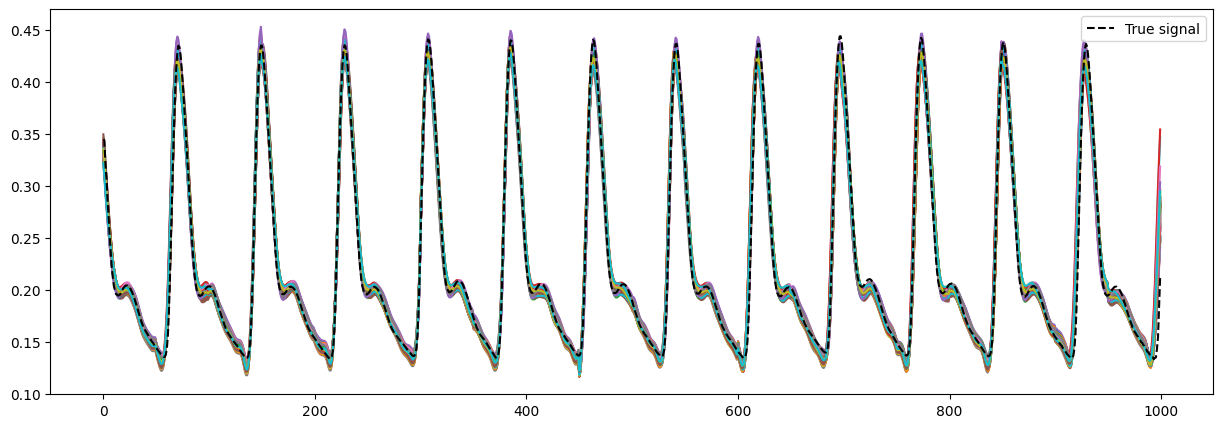

In [82]:
idx = 9871

N_Gen = 100
'''
FC_Comm = np.tile(np.linspace(0.,0.05, N_Gen )[:, None], (1,2))
FC_Each = np.tile(np.linspace(0.,0.05, N_Gen )[:, None], (1,4))

'''
FC_Comm = np.tile(np.random.uniform(0, 0.05, N_Gen)[:, None], (1,2))
FC_Comm = np.sort(FC_Comm)
FC_Each = np.tile(np.random.uniform(0, 0.05, N_Gen)[:, None], (1,4))
FC_Each = np.sort(FC_Each) 


RecPred, HH,HL,LH, LL = VisReconExtractZ_FC (AnalData, idx, FeatExtModel, ReconModel, FC_Comm, FC_Each, N_Gen=N_Gen)